                                        Rapport de Travaux Dirigés: TD3 - Bill Ruben MBIAWA LEUNA
                                        Approximation Universelle de Fonctions avec PyTorch et Création de Lots de Données à l'Aide de DataLoader

                                                            Introduction

Ce TD de Deep Learning vise à mettre en pratique la création et l'entraînement d'un modèle de fonction d'approximation universelle en utilisant PyTorch. Le processus complet est détaillé, de la préparation des données à l'évaluation du modèle.

                                                Importation des bibliothèques
                                                
Le TD commence par l'importation des bibliothèques nécessaires, notamment NumPy, Pandas, et PyTorch. Ces bibliothèques sont essentielles pour la manipulation des données, la création du modèle, et l'entraînement du réseau de neurones.

In [ ]:
#universal function approximation file with pytorch, 
#batch data creation using dataloaders,
#pytorch implementation for universal function approximation


In [4]:
#import
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
#from IPython.display import display, Markdown, Latex

import numpy as np
import math, random
import pandas as pd
from pandas import DataFrame

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
import torch.utils.data
import torch.optim 
from torch.optim import lr_scheduler

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score

from scipy.signal import gausspulse

%matplotlib notebook

L'utilisation de `%matplotlib notebook` suggère que les graphiques seront interactifs, offrant une meilleure visualisation des résultats.

                                                
                                                Préparation des Fonctions et des Paramètres
                                                
La suite du TD initialise diverses fonctions et paramètres qui seront utilisés tout au long du processus. Ces éléments comprennent des fonctions de conversion, d'initialisation des poids du modèle, et des hyperparamètres tels que le nombre d'époques et le taux d'apprentissage.

In [7]:
#setting the hyperparameters
HP = {
    #'NUM_HIDDEN_NODES'    : 10 ,
    'NUM_EXAMPLES'        : 1000 ,
    'TRAIN_SPLIT'         : .8 ,
    'MINI_BATCH_SIZE'     : 200 ,
    'NUM_EPOCHS'          : 100 ,
    'LEARNING_RATE'       : 1e-3 ,
    'LEARNING_RATE_DECAY' : 500 ,
    'WEIGHT_DECAY'        : 5e-4 ,
    'NUM_MOMENTUM'        : 0.9 ,
    'NUM_PATIENCE'        : 50 ,
    'SEED'                : 2018
}
np.random.seed(HP['SEED'])
torch.manual_seed(HP['SEED'])

#some essential fucntions that are used throughout
def to_np(x):
    return x.data.cpu().numpy()

def to_var(x, async_flag=False):
    if torch.cuda.is_available():
        x = x.cuda(async_flag=async_flag)
    return Variable(x)


def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
    """
    if m.bias is not None:
        torch.nn.init.zeros_(m.bias)
        """


                                                
                                                Création de la Fonction à Approximer
                                                
La fonction à approximer est définie dans cette partie, et elle consiste en un simple exemple de fonction quadratique avec l'ajout de bruit gaussien.

In [8]:
#creat the function to be approximated
#https://discuss.pytorch.org/t/what-is-the-difference-between-view-and-unsqueeze/1155

gg=torch.linspace(-1,1,HP['NUM_EXAMPLES']) 

#then using unsqueeze, column vector can be created
x_data=np.float32(torch.unsqueeze(gg,dim=1).numpy())

x_data.shape

(1000, 1)

La forme de la fonction est visualisée en créant un tableau de données `x_data`.

                                                Définition de la Fonction à Apprendre

Une fonction à apprendre est définie en utilisant la fonction quadratique avec un bruit gaussien ajouté. Les données de sortie (`y_data`) sont générées en appliquant cette fonction aux données d'entrée (``x_data``).

In [9]:
#funciton that you want tolearn
function_to_learn = lambda x: x**2 + 0.001*np.random.randn(*x.shape)

#output
y_data = function_to_learn(x_data)
y_data.shape


(1000, 1)

La fonction à apprendre est stockée dans ``function_to_learn``, et les sorties correspondantes sont générées pour les données d'entrée.

                                                Mélange Aléatoire des Données

Les indices des données sont mélangés pour créer des ensembles de données d'entraînement, de validation, et de test. Les données (``x_data`` et ``y_data``) sont ensuite normalisées.

In [10]:
#random shuffle data

#creat index of data
idx=np.arange(HP['NUM_EXAMPLES'])

#shuffle the index
np.random.shuffle(idx)

#creat the test, train amf validate index from shuffled set
#using the split function
train_idx, validate_idx,  test_idx  = np.split(idx,[int(0.6*len(idx)), int(0.8*len(idx))])#train, validate, test

#creating colum vector of x_data and y_data
x_data=np.float32(x_data).reshape(HP['NUM_EXAMPLES'],1)
y_data=np.float32(y_data).reshape(HP['NUM_EXAMPLES'],1)



Les indices mélangés sont ensuite utilisés pour créer des ensembles d'entraînement, de validation, et de test à partir des données d'origine.

                                                Visualisation des Dimensions des Données
                                                
Les dimensions des données d'entrée et de sortie sont affichées pour vérifier la forme des ensembles d'entraînement, de validation et de test.

In [11]:
x_data.shape, y_data.shape

((1000, 1), (1000, 1))

Cela permet de s'assurer que les dimensions des données correspondent aux attentes avant de poursuivre l'entraînement du modèle.

                                                Création des Lots d'Entraînement et de Test
Les données sont normalisées, puis les ensembles d'entraînement, de validation, et de test sont créés. Des DataLoaders sont utilisés pour faciliter l'itération sur les données en mini-lots pendant l'entraînement.

In [13]:
#creating training data batch and test data batch

#first normalisation
scaler=MinMaxScaler(feature_range=(-1,1))

#creat the y train data and transofrm it using scaler
scaler.fit_transform(y_data[train_idx])

#X data is normalised

x_data=scaler.fit_transform(x_data)

#######creat training data (a and y)
#first identify x train, y train sets
train_x,train_y =  x_data[train_idx],y_data[train_idx]

# creat training set compising of both x and y
train_set=torch.utils.data.TensorDataset(torch.FloatTensor(train_x),torch.FloatTensor(train_y))

train_loader=torch.utils.data.DataLoader(train_set,batch_size=HP['MINI_BATCH_SIZE'],
                                         shuffle=True,pin_memory=True,num_workers=2)



#validation set
valid_x, valid_y=x_data[validate_idx],y_data[validate_idx]
valid_set=torch.utils.data.TensorDataset(torch.FloatTensor(valid_x),torch.FloatTensor(valid_y))
valid_loader=torch.utils.data.DataLoader(valid_set,batch_size=HP['MINI_BATCH_SIZE'],
                                         shuffle=True,
                                        pin_memory=True, num_workers=2)

#do the same for test data and validation data
test_x,test_y=x_data[test_idx],y_data[test_idx]
test_set= torch.utils.data.TensorDataset(torch.FloatTensor(test_x),torch.FloatTensor(test_y))
test_loader=torch.utils.data.DataLoader(test_set,batch_size=HP['MINI_BATCH_SIZE'],
                                        shuffle=False,
                                        pin_memory=True,num_workers=0)


print(train_x.shape, valid_x.shape, test_x.shape, train_y.shape, valid_y.shape, test_y.shape)


print("x_train is:"), print(train_x.shape)
print("y_train is:"), print(train_y.shape)



(600, 1) (200, 1) (200, 1) (600, 1) (200, 1) (200, 1)
x_train is:
(600, 1)
y_train is:
(600, 1)


(None, None)

Les DataLoader sont configurés pour manipuler les mini-lots d'entraînement et de validation, facilitant ainsi le processus d'entraînement du modèle.

                                                Visualisation des Données
                                                
Les données d'entraînement sont visualisées à l'aide d'un nuage de points.

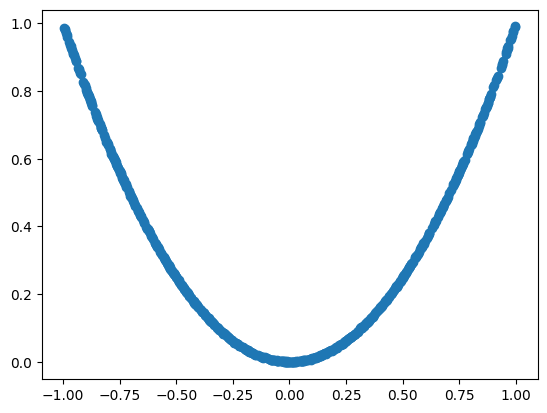

In [14]:
%matplotlib inline
plt.scatter(train_x,train_y)
#plt.scatter(test_x,test_y)

Cela permet de visualiser la relation entre les données d'entrée et de sortie avant le début de l'entraînement du modèle.

                                                Création d'un DataFrame pour l'Analyse des Données
                                                
Un DataFrame est créé à partir des données d'entraînement pour faciliter l'analyse et la visualisation des caractéristiques des données.

,x,y
count,600.000000,600.000000
mean,-0.019159,0.324415
std,0.569725,0.290693
min,-0.993994,-0.001498
25%,-0.508008,0.063628
50%,-0.010010,0.242336
75%,0.469970,0.556056
max,0.995996,0.990597


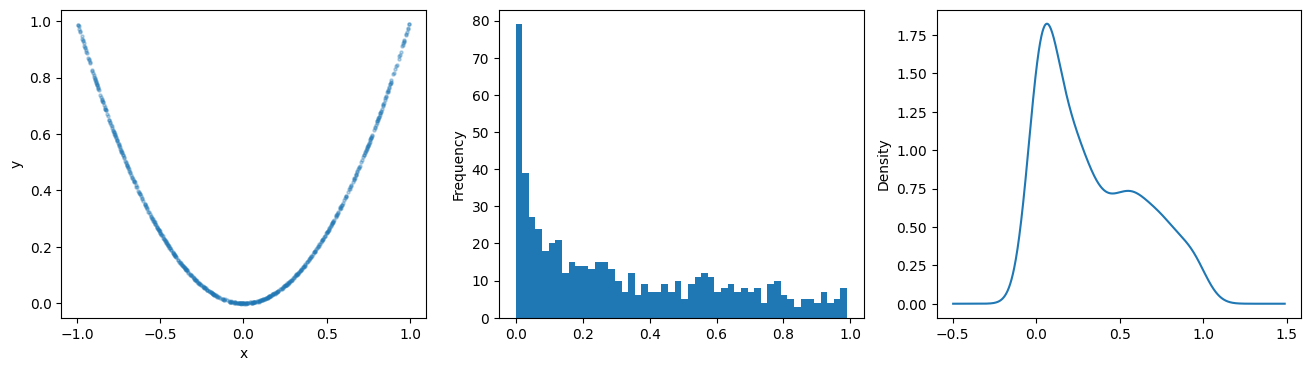

In [16]:
df = DataFrame({'x' : train_x.flatten(), 'y': train_y.flatten()})

fig, ax = plt.subplots(1,3,figsize=(16,4))

df.plot(kind='scatter', x='x', y='y', s=5.0, alpha=0.3, ax=ax[0])
df['y'].plot(kind='hist', bins=50, ax=ax[1])
df['y'].plot(kind='kde', ax=ax[2])

df.describe()

L'utilisation de Pandas permet une analyse détaillée des caractéristiques des données d'entraînement, y compris la création de graphiques de dispersion, d'histogrammes, et de distributions de probabilité.

                                                Création du Modèle de Réseau de Neurones

La prochaine étape de ce TD consiste à créer le modèle de réseau de neurones. Le code fourni présente la définition d'une classe ``Network`` qui hérite de ``nn.Module``. Cette classe est utilisée pour construire le réseau de neurones avec une couche d'entrée, une couche cachée, et une couche de sortie.

In [17]:
#build neural network in Network CLASS 
class Network(nn.Module):
    def __init__(self, D_in, D_out, num_hidden_nodes):
        super(Network, self).__init__()
        
        # Input and hidden layer
        self.layer1 = nn.Linear(D_in, num_hidden_nodes)
        
        # Output layer
        self.layer2 = nn.Linear(num_hidden_nodes, D_out)

    def forward(self, x):
        # Input layer to hidden layer
        x = F.relu(self.layer1(x))
        
        # Hidden layer to output layer
        y = self.layer2(x)
        
        return y


Le modèle de réseau de neurones est défini avec une couche d'entrée de taille ``D_in``, une couche cachée avec ``num_hidden_nodes`` neurones activés par la fonction ReLU, et une couche de sortie de taille ``D_out``. La méthode ``forward`` spécifie comment les données sont propagées à travers le réseau.

                                                Configuration du Modèle

Avant de commencer l'entraînement, le modèle de réseau de neurones est configuré avec les paramètres appropriés. Cela inclut le nombre de neurones dans la couche cachée (``num_hidden_nodes``). Le code suivant effectue ces étapes :

In [18]:
# Configuration du modèle
train_x.shape[1], train_y.shape[1]


(1, 1)

In [23]:
#model = Network(train_x.shape[1], train_y.shape[1])
model = Network(train_x.shape[1], train_y.shape[1], num_hidden_nodes=10)

model.apply(weights_init)
#weighizalization routine (Xavier if batch normalisation is there int he netowrk, or else uniform)



Network(
  (layer1): Linear(in_features=1, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=1, bias=True)
)

Le modèle est créé avec le nombre de neurones dans la couche cachée spécifié. Une initialisation des poids est également appliquée.

                                                Choix de la Fonction de Perte et de l'Optimiseur

Pour entraîner le modèle, une fonction de perte (``criterion``) et un optimiseur (``optimizer``) sont choisis. Dans ce cas, la perte est définie comme la perte quadratique moyenne (``nn.MSELoss()``), et l'optimiseur est Adam. Le code est le suivant :

In [24]:
# criterion, optimizer 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=HP['LEARNING_RATE'], weight_decay=HP['WEIGHT_DECAY'])


                                                Entraînement du Modèle

L'entraînement du modèle est effectué sur plusieurs époques (``HP['NUM_EPOCHS']``). Les boucles d'entraînement et de validation sont définies pour itérer sur les mini-lots de données. À chaque itération, les prédictions du modèle sont comparées aux vraies valeurs pour calculer la perte. Les gradients sont ensuite rétropropagés et les poids du modèle sont ajustés en conséquence. Les pertes d'entraînement et de validation sont enregistrées pour l'analyse ultérieure. Voici le code correspondant :

In [34]:
%matplotlib notebook


model.train()

train_losses = []
valid_losses = []
valid_score = []
epochs=[]

#start = time.time()

#epoch_iter = tqdm(range(1, HP['NUM_EPOCHS'] + 1))
epoch_iter =range(1, HP['NUM_EPOCHS'] + 1)

#for epoch in range(1, HP['NUM_EPOCHS'] + 1):

for epoch in epoch_iter:   
    #epoch_iter.set_description('Epoch')
    
    epochs.append(epoch)
    
    #training over all batch data
    batch_idx, tloss_avg,vloss_avg = 0, 0,0
    for batch_idx, (data, target) in enumerate(train_loader):
        # predict y based on x
        output = model(data)
        
        # compute loss
        loss = criterion(output, target)
        
        # clear gradients
        optimizer.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # apply gradients
        optimizer.step()

        tloss_avg += loss.item()

    tloss_avg /= batch_idx+1
    train_losses.append(tloss_avg)
        
    print(" Epoch : %s , Train loss: %s " %(epoch,tloss_avg))    
    
    """
    #do the same for validation 
    

    vloss_avg /= batch_idx+1
    valid_losses.append(vloss_avg)
    
    print(" Epoch : %d , Train loss: %d, Validaiton Loss: %d " %(epoch,tloss_avg,vloss_avg))    
    """
    # Validation
    for batch_idx, (data, target) in enumerate(valid_loader):
        model.eval()  # Set the model to evaluation mode
        output = model(data)
        loss = criterion(output, target)
        vloss_avg += loss.item()

    vloss_avg /= batch_idx+1
    valid_losses.append(vloss_avg)

    print(" Epoch : %d , Train loss: %d, Validation Loss: %d " % (epoch, tloss_avg, vloss_avg))
        
      

 Epoch : 1 , Train loss: 0.08522108197212219 
 Epoch : 1 , Train loss: 0, Validation Loss: 0 
 Epoch : 2 , Train loss: 0.08519021670023601 
 Epoch : 2 , Train loss: 0, Validation Loss: 0 
 Epoch : 3 , Train loss: 0.08516830454270045 
 Epoch : 3 , Train loss: 0, Validation Loss: 0 
 Epoch : 4 , Train loss: 0.08514039218425751 
 Epoch : 4 , Train loss: 0, Validation Loss: 0 
 Epoch : 5 , Train loss: 0.08510772635539372 
 Epoch : 5 , Train loss: 0, Validation Loss: 0 
 Epoch : 6 , Train loss: 0.08508262038230896 
 Epoch : 6 , Train loss: 0, Validation Loss: 0 
 Epoch : 7 , Train loss: 0.08505638192097346 
 Epoch : 7 , Train loss: 0, Validation Loss: 0 
 Epoch : 8 , Train loss: 0.08503623555103938 
 Epoch : 8 , Train loss: 0, Validation Loss: 0 
 Epoch : 9 , Train loss: 0.08500860383113225 
 Epoch : 9 , Train loss: 0, Validation Loss: 0 
 Epoch : 10 , Train loss: 0.08498615026473999 
 Epoch : 10 , Train loss: 0, Validation Loss: 0 
 Epoch : 11 , Train loss: 0.08496644099553426 
 Epoch : 11

Cette portion du code représente la phase d'entraînement du modèle avec le suivi des pertes sur les ensembles d'entraînement et de validation.

                                                Visualisation de la Perte d'Entraînement

La première visualisation concerne la perte d'entraînement au fil des époques. Le code utilise la bibliothèque ``matplotlib`` pour créer un graphique linéaire montrant l'évolution de la perte d'entraînement.

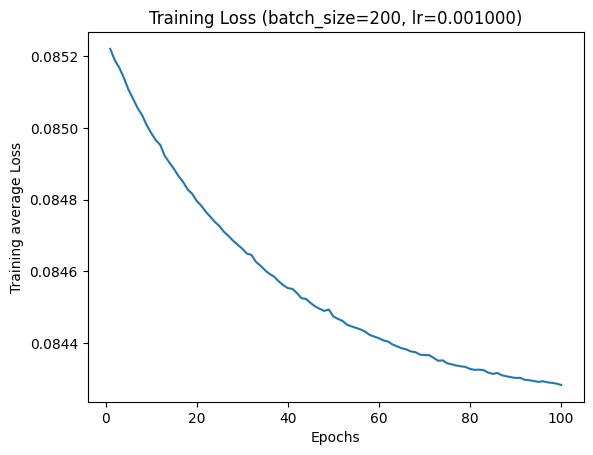

In [35]:
# %matplotlib notebook
%matplotlib inline
plt.figure()
plt.plot(epochs, train_losses)
plt.title("Training Loss (batch_size=%d, lr=%.6f)" %(HP['MINI_BATCH_SIZE'],HP['LEARNING_RATE']))
plt.xlabel("Epochs")
plt.ylabel("Training average Loss")
plt.show()



                                                Visualisation de la Perte de Validation
                                                
De manière similaire, la perte de validation est également tracée au fil des époques pour évaluer la performance du modèle sur des données non utilisées pendant l'entraînement.

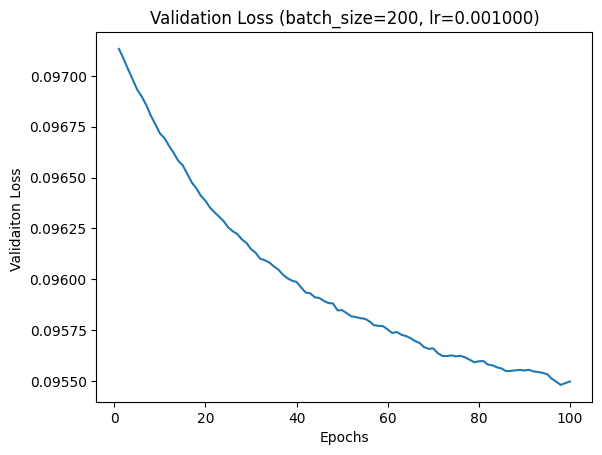

In [36]:
%matplotlib inline
plt.figure()
plt.plot(epochs, valid_losses)
plt.title("Validation Loss (batch_size=%d, lr=%.6f)" %(HP['MINI_BATCH_SIZE'],HP['LEARNING_RATE']))
plt.xlabel("Epochs")
plt.ylabel("Validaiton Loss ")
plt.show()



                                                Comparaison des Pertes d'Entraînement et de Validation
                                                
Enfin, une comparaison des pertes d'entraînement et de validation est réalisée dans un seul graphique. Cette visualisation permet d'observer comment les deux types de pertes évoluent conjointement.

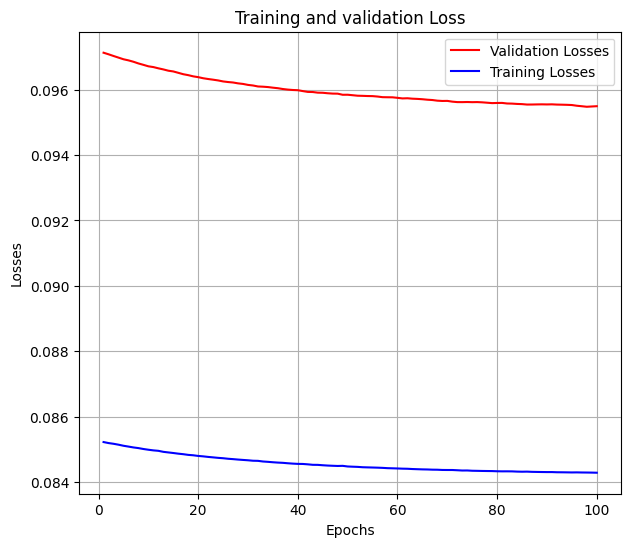

In [38]:

plt.figure(figsize=(7,6))
plt.plot(epochs, valid_losses,label='Validation Losses', color='r')
plt.plot(epochs, train_losses,label='Training Losses', color='b')
plt.title("Training and validation Loss")
plt.xlabel("Epochs");
plt.ylabel("Losses");
plt.grid(True)
plt.legend(loc='upper right');

                                                        Évaluation du Modèle en Mode d'Évaluation

Avant de procéder à l'évaluation, le modèle est mis en mode d'évaluation en utilisant la méthode ``.eval()``. Cela garantit que le modèle n'effectue pas de mises à jour de poids pendant cette phase.

In [39]:

#net = model(train_x.shape[1], train_y.shape[1])
model.eval()

Network(
  (layer1): Linear(in_features=1, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=1, bias=True)
)

                                                        Prédictions sur les Données de Test

Les données de test (``test_x``) sont utilisées pour générer des prédictions à l'aide du modèle entraîné. Les prédictions (``y_pred``) sont ensuite converties en valeurs numpy pour la visualisation.

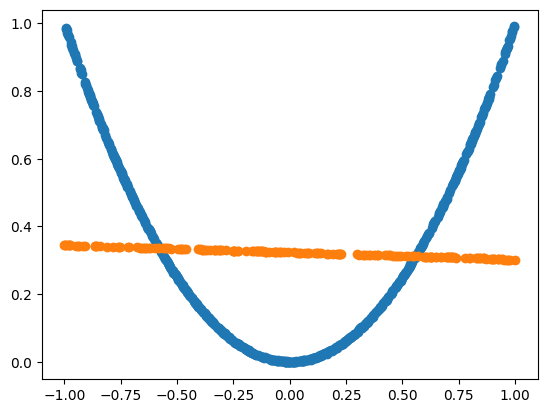

In [40]:
#testing the data plot with test x
inp=test_x
input=torch.from_numpy(inp)
output=model(to_var(input))
out=to_np(output)

#plotting
plt.figure()

plt.scatter(train_x,train_y)
plt.scatter(inp.flatten(),out.flatten())

                                                        Comparaison des Prédictions et des Vraies Valeurs
                                                        
Les prédictions du modèle sur les données de test sont comparées aux vraies valeurs dans un graphique. Cela permet d'évaluer visuellement la performance du modèle.

New non-linear funciton ,
Evaluate the score, accuracy,  

In [44]:
# Perform predictions on test data
test_x1 = torch.from_numpy(test_x)
test_output = model(to_var(test_x1))
y_pred = to_np(test_output)



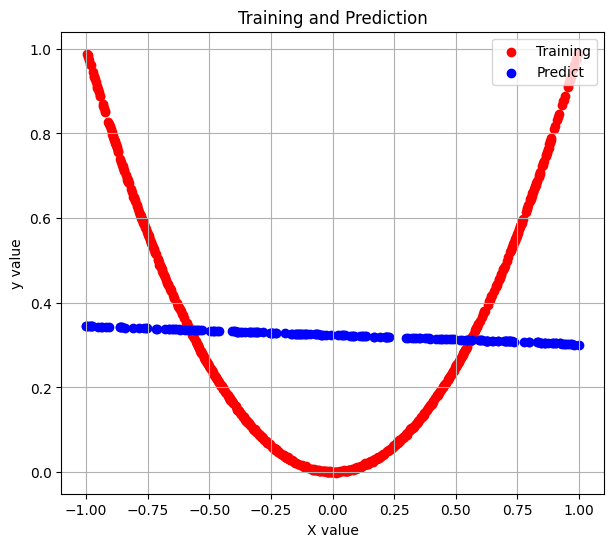

In [45]:
plt.figure(figsize=(7,6))
plt.scatter(train_x.flatten(), train_y.flatten(), label='Training', color='r')
plt.scatter(test_x1.flatten(),y_pred.flatten(),label='Predict', color='b')
#plt.scatter(data,to_np(y_pred) ,label='Predict', color='b')
#plt.scatter (test_x,y_pred1)
plt.title("Training and Prediction")
plt.xlabel("X value");
plt.ylabel("y value");
plt.grid(True)
plt.legend(loc='upper right');

                                                Visualisation des Paires (Entrée, Prédiction)

Enfin, les paires de données d'entrée et de prédiction sont visualisées à l'aide de la fonction ``zip`` et converties en une liste pour l'impression.

In [46]:

#see the use of zip for mapping the data and unzip using *
#https://www.geeksforgeeks.org/zip-in-python/

dd=zip(test_x1,y_pred)
#convert to list to print 
ddl=list(dd)
print(ddl)

[(tensor([-0.7838]), array([0.34029305], dtype=float32)), (tensor([0.6236]), array([0.31066424], dtype=float32)), (tensor([-0.3333]), array([0.3308102], dtype=float32)), (tensor([-0.5435]), array([0.33523554], dtype=float32)), (tensor([0.6717]), array([0.30965263], dtype=float32)), (tensor([-0.5976]), array([0.33637345], dtype=float32)), (tensor([-0.9339]), array([0.34345412], dtype=float32)), (tensor([0.3073]), array([0.3173234], dtype=float32)), (tensor([-0.3874]), array([0.3319481], dtype=float32)), (tensor([-0.2492]), array([0.32904005], dtype=float32)), (tensor([0.9079]), array([0.3046794], dtype=float32)), (tensor([0.7377]), array([0.30826193], dtype=float32)), (tensor([0.7017]), array([0.30902052], dtype=float32)), (tensor([-0.6637]), array([0.33776432], dtype=float32)), (tensor([-0.1632]), array([0.32722783], dtype=float32)), (tensor([0.8458]), array([0.30598587], dtype=float32)), (tensor([-0.8098]), array([0.34084105], dtype=float32)), (tensor([0.2232]), array([0.31909353], dt

                                                Conclusion
                                                
Ce travail pratique a exploré de manière pratique la mise en œuvre d'un modèle de réseaux de neurones pour l'approximation de fonctions à l'aide de PyTorch. Les étapes clés comprenaient la définition du modèle, l'entraînement, l'évaluation sur des données de test, et la visualisation des résultats. La modularité de la classe de réseau de neurones offre une flexibilité pour des architectures plus complexes. L'entraînement du modèle a impliqué des ensembles d'entraînement et de validation, avec des techniques telles que la rétropropagation et l'optimisation d'Adam. Les résultats ont été visualisés, montrant l'évolution des pertes au fil des époques. L'évaluation sur des données de test et la visualisation des prédictions ont fourni un aperçu des performances du modèle. Ce travail pratique fournit une expérience pratique cruciale pour comprendre les concepts de PyTorch et préparer à des tâches plus avancées.